#Demo de TF-Agents para resolver el problema de encontrar un Máximo Óptimo definido al azar en un plano y tratando de esquivar los máximos locales aleatorios:


0) Preparar el ambiente:

In [1]:
#@title Instalar Paquete de TF-Agents
##!pip install -q tf-agents

# usar esta versión para evitar error 
!pip install tf-agents[reverb]
!git clone https://github.com/tensorflow/agents.git
!cd agents
!git checkout v0.13.0
print("TF-Agentes instalado.")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 16.1 MB/s 
     |████████████████████████████████| 18.3 MB 114 kB/s 
     |████████████████████████████████| 6.5 MB 60.0 MB/s 
     |████████████████████████████████| 511.7 MB 6.0 kB/s 
     |████████████████████████████████| 438 kB 58.8 MB/s 
     |████████████████████████████████| 5.8 MB 54.5 MB/s 
     |████████████████████████████████| 1.6 MB 59.0 MB/s 
  Attempting uninstall: gast
    Found existing installation: gast 0.5.3
    Uninstalling gast-0.5.3:
      Successfully uninstalled gast-0.5.3
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully 

In [2]:
#@title Cargar Librerías
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import abc
import tensorflow as tf
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import random
from random import randint, sample
import math
import operator
import copy
import pickle
import codecs
import IPython


from tf_agents.environments import py_environment
from tf_agents.environments import tf_py_environment

from tf_agents.environments import utils
from tf_agents.specs import array_spec

from tf_agents.policies import random_tf_policy

from tf_agents.trajectories import time_step as ts

from tf_agents.agents.dqn import dqn_agent
from tf_agents.networks import q_network
from tf_agents.agents.categorical_dqn import categorical_dqn_agent
from tf_agents.networks import categorical_q_network

from tf_agents.utils import common

from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory

import os
from tf_agents.policies import policy_saver

tf.compat.v1.enable_v2_behavior()

print("Librerías cargadas.")

Librerías cargadas.


1) Establecer las clases sobre el Problema a resolver:

In [3]:
#@title Parámetros Generales:
# Cantidad de Máximos Locales
CANT_MAXIMOS_LOCALES = 3 #@param {type:"slider", min:0, max:10, step:1}

# Espacio mínimo y máximo del espacio de búsqueda
MIN_ESPACIO_BUSQ = -1000 #@param {type:"slider", min:-1000, max:0, step:5}
MAX_ESPACIO_BUSQ = 1000 #@param {type:"slider", min:0, max:1000, step:10}

# Cantidad  Particulas en cada una para PG
CANT_PARTICULAS = 5 #@param {type:"slider", min:1, max:10, step:1}

print("Parámetros definidos.")

Parámetros definidos.


In [4]:
#@title Definir clase MAPA DE BÚSQUEDA (notar que es la misma usada en CE)

class MapaBusqueda(object):

    def __init__(self, limMin, limMax, cantMaximosLocales=0):
          self.limMin = limMin
          self.limMax = limMax
          self.cantMax = cantMaximosLocales
          self.generarPosicionesRnd()

    def generarPosicionesRnd(self):
      
        # Define Posiciones Random para Máximos Locales y Óptimos
        # con Heurística también al Azar (entre 1 y 100)
        # controla que el máximo local/global no se ubique en la misma posición que el Hormiguero
        self.MaximosPos = []
        self.MaximosVal = []
        self.MaxOptimoID = 0
        auxMejorVal = -99
        i = 0
        while len(self.MaximosPos)<(self.cantMax+1):

            auxPos = [ random.randint(self.limMin, self.limMax),  random.randint(self.limMin, self.limMax) ]        
            auxVal = random.randint(-20, 100)

            self.MaximosPos.append( auxPos )
            self.MaximosVal.append( auxVal )
            
            if self.MaximosVal[self.MaxOptimoID] < auxVal:
                self.MaxOptimoID = i
            i= i + 1

        return True
   
    def printInformacion(self):
        # Muestra la información sobre el Mapa de Búsqueda
        print("\n** Máximos Generados: ", len(self.MaximosPos))
        for auxPos, auxVal in zip(self.MaximosPos, self.MaximosVal):
            print("  -->", auxPos, "{ ", auxVal, " } ")
        print("\n** Posición Máximo Óptimo: ", self.MaximosPos[self.MaxOptimoID], " { ",  self.MaximosVal[self.MaxOptimoID]," } **")
        print("\n")

    @property
    def posMaximos(self):
        return self.MaximosPos    

    @property
    def valMaximos(self):
        return self.MaximosVal   
        
    @property
    def posMaximoGlobal(self):
        return self.MaximosPos[self.MaxOptimoID]         
    
    @property
    def valMaximoGlobal(self):
        return self.MaximosVal[self.MaxOptimoID]  

    def estaEnMaximo(self, posicion):
      # Indica si la posición corresponde o no a un Máximo 
      # si es verdadero devuelve el valor correspondiente, sino 0
      for i in range(len(self.MaximosPos)):
        if posicion==self.MaximosPos[i]:
          return self.MaximosVal[i]
      return 0

    def funcHeuristica(self, posicion):
        # Define la Función Heurística para evaluar una posicion del mapa
        devuelve = 0
        disPosMenor = self.limMax
        for posMax, valMax in zip(self.MaximosPos, self.MaximosVal):

              # calcula la distancia al punto de la Particula
              sqerrors = ((x - y)**2 for x, y in zip(posicion, posMax))
              distPos =  math.fsum(sqerrors)**0.5 / 10
              
              # Si es la menor distancia calcula la Heurística
              if disPosMenor > distPos:
                  disPosMenor = distPos 
                  devuelve = ( valMax - distPos ) 

          # Por las dudas controla que devuelva un valor positivo
        return max(devuelve, 0)

print("\nClase Mapa de Búqueda definida") 



Clase Mapa de Búqueda definida


In [5]:
#@title Definir clase PARTICULA (la misma usada para Programación Genética)

class ParticulaPG(object):
    
    def __init__(self, mapa):        
        self.mapa = mapa
        self.pos = [random.randint(self.mapa.limMin, self.mapa.limMax) for _ in range(2)]
        self.valor = self.mapa.funcHeuristica(self.pos)        
        

    def _reset(self):
        self.pos = []
        self.valor = -9999
        self.velocidad = []

    @property
    def heuristica(self):
        return round(self.valor, 2)

    @property
    def posicion(self):
        return self.pos   


    def cambiarPosicion(self, nPos):
      if len(self.pos) == len(nPos):
        # cambia a la nueva posición indicada
        for i in range(len(self.pos)):    
          self.pos[i] = nPos[i]
      
      # actualiza su heurística
      self.valor = self.mapa.funcHeuristica(self.pos)

      return self.pos

    def moverseAzar(self, distMaxima=100):
     
      for i in range(len(self.pos)):        
          # ajusta la posición de la partícula al azar
          ajusteVel = random.uniform(self.mapa.limMin//10, self.mapa.limMax//10)
          if ajusteVel > distMaxima:
            ajusteVel = distMaxima
          self.pos[i] = self.pos[i] + int(ajusteVel)

          # revisa no haber superado los límites del mapa
          if self.pos[i] < self.mapa.limMin:
                self.pos[i] = self.mapa.limMin
          elif self.pos[i] > self.mapa.limMax:
                self.pos[i] = self.mapa.limMax

      # actualiza su heurística
      self.valor = self.mapa.funcHeuristica(self.pos)

      return self.pos

    def moverseAtraido(self, mejorCiclo, coefAtraccMejorCiclo=1.5, distMaxima=100):
        
        for i in range(len(self.pos)):
            # calcula el desplazamiento (velocidad) en base a la atracción a la mejor del ciclo
            ajusteVel = random.uniform(self.mapa.limMin//10, self.mapa.limMax//10)
            ajusteVel = ajusteVel + (coefAtraccMejorCiclo * random.uniform(0, 1) * (mejorCiclo.posicion[i]-self.pos[i]))                       
            if ajusteVel > distMaxima:
              ajusteVel = distMaxima

            # ajusta la posición de la partícula 
            self.pos[i] = self.pos[i] + int(ajusteVel)

            # revisa no haber superado los límites del mapa
            if self.pos[i] < self.mapa.limMin:
                  self.pos[i] = self.mapa.limMin
            elif self.pos[i] > self.mapa.limMax:
                  self.pos[i] = self.mapa.limMax

          # actualiza su heurística
        self.valor = self.mapa.funcHeuristica(self.pos)

        return self.pos

    def moverseAlrededor(self, mejorCiclo, radioMejor=100):
        
        for i in range(len(self.pos)):
            # ajusta posición dentro del radio de la mejor partícula
            self.pos[i] = random.randint(int(mejorCiclo.posicion[i]-radioMejor), int(mejorCiclo.posicion[i]+radioMejor)) 

            # revisa no haber superado los límites del mapa
            if self.pos[i] < self.mapa.limMin:
                  self.pos[i] = self.mapa.limMin
            elif self.pos[i] > self.mapa.limMax:
                  self.pos[i] = self.mapa.limMax

          # actualiza su heurística
        self.valor = self.mapa.funcHeuristica(self.pos)
        
        return self.pos

print("\nClase ParticulaPG definida")



Clase ParticulaPG definida


In [6]:
#@title Definir funciones para generar el Gráfico con las posiciones de las partículas

# Librerías especiales para usar
import matplotlib as mpl
from matplotlib import animation, rc
from IPython.display import HTML

# método que se usa para generar gradiente de colores
def colorFader(c1, c2, mix=0.0): #fade (linear interpolate) from color c1 (at mix=0) to c2 (mix=1)
    c1 = np.array(mpl.colors.to_rgb(c1))
    c2 = np.array(mpl.colors.to_rgb(c2))
    return mpl.colors.to_hex((1-mix)*c1 + mix*c2)

# Método que se ejecuta por cada frame para mostrar 
def updatePlot(i, ciclosPos, scat, axi, posMejorCorrida, cicloMejorCorrida):
    if axi is None or ciclosPos is None:
      return scat,

    axi.set_xlabel('Ciclo: ' + str(i), fontsize=12)
      # Si no es el último ciclo, muestra también el global
    if i<len(ciclosPos):     
      if len(ciclosPos[i])>0:          
          if MOSTRAR_HISTORICO_MOVIMIENTO:
              # Coloca nuevas posiciones correspondientes al ciclo
              # Separa las coordenadas x, y de las posiciones en el ciclo i
              X, Y = zip(*ciclosPos[i])
              ## --en Rojo: posiciones de las particulas de cada ciclo
              axi.scatter(X, Y, color='red')
          else:
              # Hace mover a las Partículas
              scat.set_offsets(ciclosPos[i])              
    
    if i>=cicloMejorCorrida:
      if posMejorCorrida is not None:
          ## --en Violeta: Mejor posición de las partículas
          if len(posMejorCorrida) == 2 and isinstance(posMejorCorrida[0], int) and  isinstance(posMejorCorrida[1], int):
              axi.scatter(posMejorCorrida[0], posMejorCorrida[1], color='violet', s=100)
          else:
              X, Y = zip(*posMejorCorrida)                      
              axi.scatter(X, Y, color='violet', s=100)

    # Devuelve una lista de "artistas" para dibujar, 
    # en este caso es sólo uno por lo que se pone una coma final
    return scat,    

# Función para preparar el gráfico          
def PrepararGrafico(mapa, MIN_ESPACIO_BUSQ, MAX_ESPACIO_BUSQ, ciclosPos, partMejorCorrida, cicloMejorCorrida): 

    #fig = plt.figure(figsize=(14,7))
    fig = plt.figure(figsize=(13,6))
    ax = fig.add_subplot(111)
    plt.close()

    textoTitulo = "Gráfico del Movimiento de las Partículas"
    textoDesc = '\n** Posición Máximo Óptimo a buscar : ' + str(mapa.posMaximoGlobal) + ' { ' +  str(mapa.valMaximoGlobal) +' } **'
    textoDesc = textoDesc + '\n== Mejor Particula: ' + str(partMejorCorrida.posicion) + ' { ' + str(round(partMejorCorrida.heuristica, 3)) + ' } =='
    textoDesc = textoDesc + '\n-- Colores:  Máximos Locales (AZUL) - Máximo Óptimo (VERDE) - '  
    textoDesc = textoDesc + '\n- Partículas (ROJO) - Mejor Partícula (VIOLETA) -- ' 

    ## -- en Azul: Máximos Locales (positivos)
    ## -- en Cyan: Mínimos Locales (negativos)
    ## -- en Verde: Máximo Óptimo
    for posi, vali in zip(mapa.posMaximos, mapa.valMaximos):    
      valRel = abs(vali / mapa.valMaximoGlobal) 
      if vali < 0:        
          c = colorFader('cyan', 'green', valRel) 
          ax.scatter(posi[0], posi[1], color=c)
      else:
          c = colorFader('blue', 'green', valRel) 
          ax.scatter(posi[0], posi[1], color=c)     
    ax.scatter(mapa.posMaximoGlobal[0], mapa.posMaximoGlobal[1], color='green', s=150)    

    # Define el tamaño de la figura
    ax.axis([MIN_ESPACIO_BUSQ, MAX_ESPACIO_BUSQ, MIN_ESPACIO_BUSQ, MAX_ESPACIO_BUSQ])

    # Separa las coordenadas x, y de las posiciones en el ciclo inicial
    X, Y = zip(*ciclosPos[0])
    ## --en Rojo: posiciones de las posiciones de cada ciclo
    scat = ax.scatter(X, Y, color='red')

    # Muestra título y texto debajo
    ax.set_title(textoTitulo)
    ax.set_ylabel(textoDesc, fontsize=11)

    # Luego setea la animación usando los dos métodos anteriores 
    cant = len(ciclosPos)
    ani = animation.FuncAnimation(fig, updatePlot, 
                                  frames=cant, interval=cant,
                                  fargs=(ciclosPos, scat, ax, partMejorCorrida.posicion, cicloMejorCorrida), 
                                  blit=True, repeat=False)
    
    return ani


# Define la configuración para el gráfico
MOSTRAR_HISTORICO_MOVIMIENTO = False

### Nota: esto se agega para que funcione en Google Colab
##rc('animation', html='jshtml')
##ani

print("Funciones para generar gráfico definidas.")

Funciones para generar gráfico definidas.


In [7]:
#@title Definir las primitivas a usar para busqueda en el espacio de búsqueda

# distancia máxima por defecto = 25% del espacio de búsqueda
PARAM_DIST_MAXIMA = (MAX_ESPACIO_BUSQ-MIN_ESPACIO_BUSQ)/4.0
PARAM_RADIO_MEJOR = PARAM_DIST_MAXIMA/2.0


def seleccPartMover(particulas, cantPartMover):
  if particulas==None and particulas!="" and len(particulas)==0:
      return particulas
  if cantPartMover <= 1:
    return sample(particulas, k=1)
  elif cantPartMover >= len(particulas):
    return particulas
  else:
    return sample(particulas, k=cantPartMover)

# función auxiliar para obtener la mejor partícula de una lista
def devuelveMejor(particulas):
  if particulas==None and particulas!="" and len(particulas)==0:
      return None
  # obtiene la mejor partícula
  rankingParticulas = sorted(copy.deepcopy( particulas ), key=operator.attrgetter('heuristica'), reverse=True)
  mejorPart = rankingParticulas[0]
  return mejorPart

def moverAzar(particulas, cantPartMover, distMaxima=PARAM_DIST_MAXIMA):
  ## función tipo Mutación de CE
  if particulas==None and particulas!="" and len(particulas)==0:
      return particulas
  if distMaxima <= 0:
    distMaxima = 1
  # determina partículas a mover al azar
  partsMover = seleccPartMover(particulas, cantPartMover)
  # mueve las partículas al azar
  for part in partsMover:
    part.moverseAzar(distMaxima)
  return particulas

def moverAzarFuncHeurist(particulas, cantPartMover, distMaxima=PARAM_DIST_MAXIMA, mutate_factor=-2.5):
  ## función tipo HiperMutar de CLONALG
  if particulas==None and particulas!="" and len(particulas)==0:
      return particulas
  if distMaxima <= 0:
    distMaxima = 1
  # determina partículas a mover al azar
  partsMover = seleccPartMover(particulas, cantPartMover)    
  # mueve las partículas al azar
  for part in partsMover:
    # calcula distancia máxima en base a la heuristica
    distMaximaHeur = distMaxima * math.exp(mutate_factor * part.heuristica/100)
    if distMaximaHeur > 0:   
      part.moverseAzar(distMaximaHeur)
  return particulas

def moverAtraidoAlMejor(particulas, cantPartMover, porcAtraccMejorCiclo=50, distMaxima=PARAM_DIST_MAXIMA):
  ## función tipo PSO
  if particulas==None and particulas!="" and len(particulas)==0:
      return particulas
  # obtiene la mejor partícula
  mejorPart = devuelveMejor(particulas)
  if distMaxima <= 0:
    distMaxima = 1
  if porcAtraccMejorCiclo > 0:
    coefAtraccMejorCiclo = porcAtraccMejorCiclo/100.0
  else:
    coefAtraccMejorCiclo = 0.0
  # determina partículas a mover al azar
  partsMover = seleccPartMover(particulas, cantPartMover)      
  # ajusta a todas en base a la mejor
  for part in partsMover:
    part.moverseAtraido(mejorPart, coefAtraccMejorCiclo, distMaxima)
  return particulas

def moverAlrededorMejor(particulas, cantPartMover, radioMejor=PARAM_RADIO_MEJOR):
  ## función tipo Abejas
  if particulas==None and particulas!="" and len(particulas)==0:
      return particulas
  if radioMejor <= 0:
    radioMejor = 1000     
  # obtiene la mejor partícula
  mejorPart = devuelveMejor(particulas)
  # determina partículas a mover al azar
  partsMover = seleccPartMover(particulas, cantPartMover)   
  # ajusta a todas en base a la mejor
  for part in partsMover:
    part.moverseAlrededor(mejorPart, radioMejor)
  return particulas

def intercambiarPos(particulas, cantIntercambios):
  ## función tipo Cruzamiento de CE
  if particulas==None and particulas!="" and len(particulas)==0:
      return particulas  
  # toma particulas de a pares 
  # (primero y último, segundo y penúltimo,...)
  # teniendo en cuenta el máximo de cantIntercambios
  # e intercambia las posiciones
  mitadPart = len(particulas)//2
  if cantIntercambios <= 0 or cantIntercambios > len(particulas):
    cantIntercambios = 2
  if mitadPart > cantIntercambios:
    mitadPart = cantIntercambios
  for part1, part2 in zip( particulas[:mitadPart:1], particulas[:mitadPart-1:-1] ):
      nPos1 = []
      nPos2 = []
      # intercambia las posiciones para posiciones impares
      for i in range(len(part1.posicion)):
        if (i%2)==0:          
          nPos1.append( part1.posicion[i] )
          nPos2.append( part2.posicion[i] )
        else:
          nPos2.append( part1.posicion[i] )
          nPos1.append( part2.posicion[i] )
      # indica las nuevas posiciones para las partículas
      # y actualiza la heurística
      part1.cambiarPosicion(nPos1)
      part2.cambiarPosicion(nPos2)
  return particulas

POSIBLES_ACCIONES_DESC = [ "moverAzar", "HiperMutarPosiciones", "moverAtraidoAlMejor", "moverAlrededorMejor", "CruzarPosiciones" ]
POSIBLES_ACCIONES = [ moverAzar, moverAzarFuncHeurist, moverAtraidoAlMejor, moverAlrededorMejor, intercambiarPos  ]

print("Primitivas de acciones definidas: ", POSIBLES_ACCIONES_DESC)

Primitivas de acciones definidas:  ['moverAzar', 'HiperMutarPosiciones', 'moverAtraidoAlMejor', 'moverAlrededorMejor', 'CruzarPosiciones']


In [8]:
#@title Definir clase del Entorno del Problema 

# parámetros generales para el entorno
HACER_MAPA_OBS = True #@param {type:"boolean"}
if HACER_MAPA_OBS:
  LISTA_OBS_TAMANIO_MAXIMO = 50 # ojo que más grande usa toda la memoria RAM
else:
  LISTA_OBS_INCLUIR_POSICIONES = False 
  LISTA_OBS_TAMANIO_MAXIMO = 1 + CANT_PARTICULAS
  if LISTA_OBS_INCLUIR_POSICIONES:
    LISTA_OBS_TAMANIO_MAXIMO = LISTA_OBS_TAMANIO_MAXIMO * 3
MAXIMO_VALOR_ACTION = (len(POSIBLES_ACCIONES)-1)*10 + 9
MIN_DIF_HEURISTICA_FINALIZAR = 1

def parsearAccion(action):
  # determina id de tipo de acción 
  idAccion = action//10
  aux = action - idAccion*10
  # determina cantidad de particulas
  porc = aux*10 + 10
  return idAccion, porc

# Un entorno que represente el juego podría verse así:
class BuscarMaxMapaEntorno(py_environment.PyEnvironment):

  def __init__(self, cantMaxIteraciones=50, resetCambiaTodo=True, Hash_configuracion_Mapa_Busqueda=None):
    self._action_spec = array_spec.BoundedArraySpec(
        shape=(), dtype=np.int32, minimum=0, maximum=MAXIMO_VALOR_ACTION, name='action')
    if HACER_MAPA_OBS:
      self._observation_spec = array_spec.BoundedArraySpec(
          shape=(LISTA_OBS_TAMANIO_MAXIMO, LISTA_OBS_TAMANIO_MAXIMO, 1, ), dtype=np.float32, name='observation')      
    else:
      self._observation_spec = array_spec.BoundedArraySpec(
          shape=(LISTA_OBS_TAMANIO_MAXIMO,), dtype=np.float32, name='observation')      
    # inicializa parámetros generales
    self._cantMaxIteraciones = cantMaxIteraciones
    # nota: tener en cuenta que si la cantidad de iteraciones es muy grande, 
    # se vuelve búsqueda exhaustiva y siempre queda muy cerca
    self._hashMapaBusq = Hash_configuracion_Mapa_Busqueda
    self._resetCambiaTodo = resetCambiaTodo  
    # inicializa variables 
    self._episode_ended = False
    self._state = 0
    # define configuración del entorno
    if self._resetCambiaTodo:
      # cada vez que se resetea se define
      self._mapaBusq = None
      self._valorMinFinalizar = 0
      self._listaPartOriginal = []      
    else:
      # sólo se generan al iniciar y se mantiene la misma
      self._mapaBusq, self._valorMinFinalizar = self.crearEspacioBusqueda(self._hashMapaBusq)    
      self._listaPartOriginal = self.crearParticulas(self._mapaBusq)
    self._listaPart = []
    self._ciclosPos = []
    self._cantIteraciones = 0
    self._mejorPartCorrida = None
    self._mejorPartCorrida_it = 0

  def action_spec(self):
    # devuelve la forma de las acciones
    return self._action_spec

  def observation_spec(self):
    # devuelve la forma de las observaciones   
    return self._observation_spec

  def _reset(self):
    # resetea el entorno
    # crea partículas
    if self._resetCambiaTodo:
      # cada vez que se reseta, se define la lista de partículas
      self._mapaBusq, self._valorMinFinalizar = self.crearEspacioBusqueda(self._hashMapaBusq)    
      self._listaPartOriginal = self.crearParticulas(self._mapaBusq)
    # siempre la lista de trabajo se copia de la original
    self._listaPart = copy.deepcopy( self._listaPartOriginal )
    # registra las posiciones iniciales de las partículas para el gráfico
    auxLista = []
    for p in self._listaPart:
      auxLista.append( copy.deepcopy( p.posicion ) )
    self._ciclosPos = [ auxLista ]
    # actualiza el estado 
    self.actualizarEstado()
    self._cantIteraciones = 0
    self._episode_ended = False
    self._mejorPartCorrida = None
    self._mejorPartCorrida_it = 0
    return ts.restart(self.devolverObsActual())

  def crearEspacioBusqueda(self, Hash_configuracion_Mapa_Busqueda=None):
    if Hash_configuracion_Mapa_Busqueda is None or Hash_configuracion_Mapa_Busqueda=="":
      # crea el espacio de búsqueda nuevo
      mapa = MapaBusqueda(limMin=MIN_ESPACIO_BUSQ, limMax=MAX_ESPACIO_BUSQ, \
                          cantMaximosLocales=CANT_MAXIMOS_LOCALES)
    else:
      # usa configuración de mapa de búsqueda definida en hash
      mapa = pickle.loads(codecs.decode(Hash_configuracion_Mapa_Busqueda.encode(), "base64"))
    # devuelve el mapa y el valor mínimo para finalizar la búsqueda
    return mapa, ((mapa.valMaximoGlobal - MIN_DIF_HEURISTICA_FINALIZAR) / 100.0)  

  def crearParticulas(self, mapaBusq):
    # Inicializa la lista de partículas 
    auxPobla = []
    for i in range(CANT_PARTICULAS):
      p = ParticulaPG(mapaBusq)
      auxPobla.append( p ) 
    return auxPobla

  def actualizarEstado(self):
    # determina mejor partícula actual
    mejorPart = devuelveMejor(self._listaPart)
    # guarda la mejor particula de la corrida
    if self._mejorPartCorrida is None or self._mejorPartCorrida.heuristica < mejorPart.heuristica:
      self._mejorPartCorrida_it = abs(self._cantIteraciones)
      self._mejorPartCorrida = copy.deepcopy( mejorPart )    
    # actualiza el valor del estado del entorno
    # teniendo la mejor heurística de las partículas de la corrida
    self._state = round( (mejorPart.heuristica / 100.0), 4) 
    return self._state

  def devolverObsActual(self):
    # devuelve valores para la observación actual
    # las posiciones de las partículas y 
    # los valores de la heurística de las partículas
    # para que el agente sepa el estado del entorno
    # nota: para DQN parece ser que conviene 
    # normalizar los valores para que sean más homogeneos 
    # y no demasiado dispares entre sí 
    # (sino genera un 'loss' demasiado grande)    
    if HACER_MAPA_OBS:
        # inicializa el mini-mapa 
        auxRes = np.zeros((LISTA_OBS_TAMANIO_MAXIMO, LISTA_OBS_TAMANIO_MAXIMO, 1), dtype=np.float32)
        # agrega nueva lista con posiciones actuales
        auxCalcPos = LISTA_OBS_TAMANIO_MAXIMO//(MAX_ESPACIO_BUSQ-MIN_ESPACIO_BUSQ)
        # marca la posición de la mejor partícula
        if self._mejorPartCorrida is not None:
          pos1 = self._mejorPartCorrida.posicion[0] * auxCalcPos
          pos2 = self._mejorPartCorrida.posicion[1] * auxCalcPos
          auxRes[pos1][pos2][0] = round(self._mejorPartCorrida.heuristica / 100.0, 4)
        # marca la heurísticas actuales de las otras partículas
        for p in self._listaPart:
          pos1 = p.posicion[0] * auxCalcPos
          pos2 = p.posicion[1] * auxCalcPos    
          auxRes[pos1][pos2][0] = round(p.heuristica / 100.0, 4)    
        return np.array(auxRes, dtype=np.float32)
    else:     
        # registra  heurística de la mejor partícula
        if self._mejorPartCorrida is None:
          res = [ (-1 / 100.0) ]
          if LISTA_OBS_INCLUIR_POSICIONES:
            res.append( -1 / MAX_ESPACIO_BUSQ )
            res.append( -1 / MAX_ESPACIO_BUSQ )          
        else:
          res = [ self._mejorPartCorrida.heuristica / 100.0 ]
          if LISTA_OBS_INCLUIR_POSICIONES:
            res.append( self._mejorPartCorrida.posicion[0] / MAX_ESPACIO_BUSQ )
            res.append( self._mejorPartCorrida.posicion[1] / MAX_ESPACIO_BUSQ )          
        # registra heurística y posiciones (opcional) actuales de todas las partículas
        for p in self._listaPart:
          if LISTA_OBS_INCLUIR_POSICIONES:
            res.append( p.posicion[0] / MAX_ESPACIO_BUSQ )
            res.append( p.posicion[1] / MAX_ESPACIO_BUSQ )
          res.append( p.heuristica / 100.0 )
        # devuelve lista de heurísticas y posiciones (opcional)
        return np.array([round(v,4) for v in res], dtype=np.float32)

  def _step(self, action):
    # aplica una acción sobre el entorno
    
    if self._episode_ended:
      # si el entorno está finalizado, lo resetea
      return self.reset()

    # actualiza cantidad de interacciones 
    self._cantIteraciones = self._cantIteraciones - 1

    # parsea la accion para determinar acción
    idAccion, porcPartMover = parsearAccion(action)

    # si es un id de acción válida
    if idAccion >= 0 and idAccion < len(POSIBLES_ACCIONES):
      # determina la cantidad de partículas a mover
      cantPartMover = (len(self._listaPart) * porcPartMover)//100
      # aplica la acción correspondiente en cada lista
      POSIBLES_ACCIONES[idAccion](self._listaPart, cantPartMover)

      # registra las nuevas posiciones de las partículas para el gráfico
      auxLista = []
      for p in self._listaPart:
        auxLista.append( copy.deepcopy( p.posicion ) )
      self._ciclosPos.append( auxLista )

      # actualiza el estado 
      self.actualizarEstado()

      # determina si debe finalizar o no
      terAlcanzaMinimo = (self._state >= self._valorMinFinalizar)
      terLlegoMaxIteraciones = (abs(self._cantIteraciones) >= abs(self._cantMaxIteraciones))
      if terAlcanzaMinimo or terLlegoMaxIteraciones:
        # si está todo ordenado 
        # o si la cantidad de iteraciones llega al límite
        # fuerza que finaliza
        self._episode_ended = True

    if self._episode_ended:
      # si finaliza
      # devuelve el reward final (siempre se maximiza)
      # usando la heuristica de la mejor partícula de la corrida
      # determina el reward a devolver
      r = self._state
      if terAlcanzaMinimo:
        # se agranda si alcanza solución para reforzar
        r = r * 10
      return ts.termination(self.devolverObsActual(), reward=r)
    else:
      # si no finaliza
      return ts.transition(
         self.devolverObsActual(), reward=self._state, discount=0.9)
         # notar que no se usa discount=1.0 porque sino genera problema de 'loss' muy grande

  def render(self, mode = 'human'):
    # muestra información sobre el entorno
    if  self._cantIteraciones==0:
      # muestra información del mapa de búsqueda
      print("\n> Mapa de Búsqueda:")
      self._mapaBusq.printInformacion()    
      # devuele el hash del mapa de búsqueda
      print("* Hash del mapa de búsqueda definido: ")
      print(codecs.encode(pickle.dumps( self._mapaBusq), "base64").decode() )
      print("> Partículas Iniciales: " )
    else:
      if self._episode_ended:
        print("> Partículas Finales: " )
      else:
        print("> Partículas: " )
    # muestra las partículas actuales
    for p in self._listaPart:      
      print("    ", p.posicion, "{", p.heuristica,"} " )
    if self._mejorPartCorrida is not None:
      # muestra la mejor partícula
      print("> Mejor Particula de la Corrida : ", self._mejorPartCorrida.posicion, "{", self._mejorPartCorrida.heuristica,"} encontrado en ciclo ", self._mejorPartCorrida_it)
      print("> Mapa de Búsqueda ** Posición Máximo Óptimo: ", self._mapaBusq.posMaximoGlobal, "{", self._mapaBusq.valMaximoGlobal,"} **")
      res = self._mejorPartCorrida.heuristica
    else:
      res = self._state * 100.0
    print("\n")
    if self._episode_ended:
      # si termino genera el gráfico con el video de la animación
      ani = PrepararGrafico(self._mapaBusq, MIN_ESPACIO_BUSQ, MAX_ESPACIO_BUSQ, self._ciclosPos,  self._mejorPartCorrida, self._mejorPartCorrida_it)    
      # Nota: esto se agega para que funcione en Google Colab
      rc('animation', html='jshtml')
      display(ani)
    return np.array(res, dtype=np.float32)

print("\nEntorno del Problema definido.")



Entorno del Problema definido.


In [9]:
#@title Definir Simulador del Entorno y Entornos para Entrenamiento 

# si se indica este  hash del mapa de búsqueda 
# siempre usa esta configuración para entrenamiento del agente
Max_Iteraciones_Entorno_para_Entrenamiento =  100#@param {type:"integer"}
if Max_Iteraciones_Entorno_para_Entrenamiento < 1:
  Max_Iteraciones_Entorno_para_Entrenamiento = 10
Usar_hash_configuracion_fija_para_Entrenamiento = True #@param {type:"boolean"}
Hash_configuracion_Mapa_Busqueda_Entrenamiento = "gANjX19tYWluX18KTWFwYUJ1c3F1ZWRhCnEAKYFxAX1xAihYBgAAAGxpbU1pbnEDShj8//9YBgAA AGxpbU1heHEETegDWAcAAABjYW50TWF4cQVLA1gKAAAATWF4aW1vc1Bvc3EGXXEHKF1xCChN3gFK kP///2VdcQkoTRkDSoH///9lXXEKKE0gA0oW/f//ZV1xCyhLhk0KAmVlWAoAAABNYXhpbW9zVmFs cQxdcQ0oS2BLYkshSx1lWAsAAABNYXhPcHRpbW9JRHEOSwF1Yi4=" #@param {type:"string"}
if Usar_hash_configuracion_fija_para_Entrenamiento:
  hash = Hash_configuracion_Mapa_Busqueda_Entrenamiento
else:
  hash = None

# Definir entornos de entrenamiento y de evaluación
# (ambos con lista que se cambia cada vez que se resetea)
# ya definidos dentro del wrapper para convertir en entornos TF
train_env = tf_py_environment.TFPyEnvironment( BuscarMaxMapaEntorno(Max_Iteraciones_Entorno_para_Entrenamiento, True, hash) )
eval_env = tf_py_environment.TFPyEnvironment( BuscarMaxMapaEntorno(Max_Iteraciones_Entorno_para_Entrenamiento, True, hash) )

# define política al azar independiente del Agente
random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),
                                                train_env.action_spec())

print("\nEntornos de entrenamiento y prueba definidos. ")

# definir simulador para probar el entorno
def SimularEntorno(env, policy, titulo, mostrarDetalle=True):
    print("\n** ", titulo, "**")                   
    # muesta estado inicial
    time_step = env.reset()      
    # muestra la información del entorno
    env.pyenv.render()
    if mostrarDetalle:
      print(" Ini: [", time_step, "]")    
    j = 1
    strAccRew = " "
    while not time_step.is_last():
      # la política determina la acción a realizar
      action_step = policy.action(time_step)
      time_step = env.step(action_step.action)
      # recupera la observación y muestra el nuevo estado 
      ac = action_step.action.numpy()[0]
      idAccion, porc = parsearAccion(ac)
      r = time_step.reward.numpy()[0]
      #ob = time_step.observation.numpy()[0]
      descAccion = POSIBLES_ACCIONES_DESC[ idAccion ] + "(" + str(porc) + "%)" 
      if mostrarDetalle:
        print("  #", j, ": acción ", descAccion, "-> Estado/Reward ", r, "[", time_step, ",", action_step, "]")
      else:
        if j > 1:
          strAccRew = strAccRew  + " + "
        strAccRew = strAccRew + descAccion + " {" + str(r) + "}" 
        if (j % 3) == 0:
          strAccRew = strAccRew  + "\n "
      j = j + 1
    # muestra estado final
    print( "> " + str(j-1)  + " Acciones: \n", strAccRew )
    # devuelve el video que genera
    resRender = env.pyenv.render()
    return resRender[0]

print("\nSimulador del entorno definido.")

# Probar el entorno definido con Política Aleatoria (opcional)
Probar_Entorno = "SI sin Detalle" #@param ["SI con Detalle", "SI sin Detalle", "NO"]
Probar_Entorno_Bool = (Probar_Entorno != "NO")
Mostrar_Detalle_Probar_Entorno_Bool = (Probar_Entorno == "SI con Detalle")
if Probar_Entorno_Bool:
   SimularEntorno(eval_env, random_policy, "Probando el entorno del problema con política al azar", Mostrar_Detalle_Probar_Entorno_Bool)
 

Output hidden; open in https://colab.research.google.com to view.

2) Establecer clase para el Agente:

In [10]:
#@title Definir el Agente (tipo DQN o DQN Categórico)

tipo_agente = "DQN" #@param ["DQN", "DQN Categorico (C51)"]
learning_rate = 1e-3  # @param {type:"number"}
cant_neuronas_ocultas = "64, 16, 8" # @param {type:"string"}
DQN_usa_capas_convNet = True # @param {type:"boolean"}
DQNCat_num_atoms = 51  # @param {type:"integer"}

# controla cantidad de atoms para DQN Cat
if DQNCat_num_atoms <= 1:
  DQNCat_num_atoms = 51

# Define cantidad de neuronas ocultas para RNA-Q
hidden_layers = []
for val in cant_neuronas_ocultas.split(','):
  if  int(val) < 1:
    hidden_layers.append( 10 )
  else:
    hidden_layers.append( int(val) )
fc_layer_params = tuple(hidden_layers, )

if tipo_agente=="DQN":

  #define las capas convolutional
  if DQN_usa_capas_convNet:
    CNN_preprocessing_layers = tf.keras.models.Sequential(
                                        [tf.keras.layers.Conv2D(2, 2, activation='relu', padding="same"),
                                         tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
                                         tf.keras.layers.Flatten()])
  else:
    CNN_preprocessing_layers = None

  # Define RNA-Q
  q_net = q_network.QNetwork(
      train_env.observation_spec(),
      train_env.action_spec(),
      preprocessing_layers=CNN_preprocessing_layers,
      fc_layer_params=fc_layer_params)

  optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)

  train_step_counter = tf.Variable(0)

  # Define el agente de tipo Q
  ag = dqn_agent.DqnAgent(
      train_env.time_step_spec(),
      train_env.action_spec(),
      q_network=q_net,
      optimizer=optimizer,
      td_errors_loss_fn=common.element_wise_squared_loss,
      train_step_counter=train_step_counter)

  ag.initialize()

  print("Agente DQN inicializado. ")

elif tipo_agente == "DQN Categorico (C51)":
  
  # Define RNA-Q Categórico
  categorical_q_net = categorical_q_network.CategoricalQNetwork(
      train_env.observation_spec(),
      train_env.action_spec(),
      num_atoms=DQNCat_num_atoms,
      fc_layer_params=fc_layer_params)

  optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)

  train_step_counter = tf.compat.v2.Variable(0)
  
  # parámetros especificos (por defecto)
  n_step_update = 2
  gamma = 0.99

  # Define el agente de tipo Q Categórico
  ag = categorical_dqn_agent.CategoricalDqnAgent(
      train_env.time_step_spec(),
      train_env.action_spec(),
      categorical_q_network=categorical_q_net,
      optimizer=optimizer,
      min_q_value=0,
      max_q_value=MAXIMO_VALOR_ACTION,
      n_step_update=n_step_update,
      td_errors_loss_fn=common.element_wise_squared_loss,
      gamma=gamma,
      train_step_counter=train_step_counter)
  
  ag.initialize()
  
  print("Agente DQN Categorico (C51) inicializado. ")


Agente DQN inicializado. 


3) Llevar a cabo el Entrenamiento:

In [11]:
#@title Definir Métricas para evaluación

# Se usa el promedio de la recompensa (la más común)
# See also the metrics module for standard implementations of different metrics.
# https://github.com/tensorflow/agents/tree/master/tf_agents/metrics

def compute_avg_return(environment, policy, num_episodes=10):

  if num_episodes <= 0:
    return 0.0
    
  total_return = 0.0
  for _ in range(num_episodes):

    time_step = environment.reset()
    episode_return = 0.0
    while not time_step.is_last():
      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      episode_return += time_step.reward
    total_return += episode_return

  avg_return = total_return / num_episodes
  return avg_return.numpy()[0]

print("Métricas definidas.")

Métricas definidas.


In [12]:
#@title Preparar datos para Entrenamiento

initial_collect_steps =   10000# @param {type:"integer"} 
collect_steps_per_iteration =   100# @param {type:"integer"}
replay_buffer_max_length = 100000  # @param {type:"integer"}
batch_size = 64  # @param {type:"integer"}

# Define 'Replay Buffer' para que el agente recuerde las observaciones realizadas
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec = ag.collect_data_spec,
    batch_size = train_env.batch_size,
    max_length = replay_buffer_max_length)

# Recolecta datos generados al azar
# This loop is so common in RL, that we provide standard implementations. 
# For more details see the drivers module.
# https://www.tensorflow.org/agents/api_docs/python/tf_agents/drivers

def collect_step(environment, policy, buffer):
  time_step = environment.current_time_step()
  action_step = policy.action(time_step)
  next_time_step = environment.step(action_step.action)
  traj = trajectory.from_transition(time_step, action_step, next_time_step)

  # Add trajectory to the replay buffer
  buffer.add_batch(traj)

def collect_data(env, policy, buffer, steps=1):
  for _ in range(steps):
    collect_step(env, policy, buffer)

collect_data(train_env, random_policy, replay_buffer, initial_collect_steps)

print("\nDatos recolectados.")

# Muestra ejemplo de los datos recolectados
##iter(replay_buffer.as_dataset()).next()

if tipo_agente=="DQN":
  # Preparar los datos recolectados con trajectories de shape [Bx2x...]
  dataset = replay_buffer.as_dataset(
      num_parallel_calls=3, 
      sample_batch_size=batch_size, 
      num_steps=2).prefetch(3)
elif tipo_agente == "DQN Categorico (C51)":
  # Dataset generates trajectories with shape [BxTx...] where
  # T = n_step_update + 1.
  dataset = replay_buffer.as_dataset(
      num_parallel_calls=3, sample_batch_size=batch_size,
      num_steps=n_step_update + 1).prefetch(3)

iterator = iter(dataset)

# Muestra ejemplo 
##iterator.next()
print("\nDataset creado.")


Datos recolectados.
Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.

Dataset creado.


In [13]:
#@title Entrenar al Agente

cant_ciclos_entrenamiento_finalizar =  5000# @param {type:"integer"}
minima_recompensa_promedio_finalizar = 100 # @param {type:"integer"}
log_cada_ciclos = 200  # @param {type:"integer"}
mostar_recompensa_cada = 1000  # @param {type:"integer"}
cant_episodios_evaluacion =  10# @param {type:"integer"}

#  Optimize by wrapping some of the code in a graph using TF function (Optional)
ag.train = common.function(ag.train)

# Reset the train step
ag.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, ag.policy, cant_episodios_evaluacion)
ar_ciclo = []
ar_returns = []
ar_loss = []

print("\n** Comienza el Entrenamiento **\n")
for _ in range(cant_ciclos_entrenamiento_finalizar):

  # Collect a few steps using collect_policy and save to the replay buffer.
  collect_data(train_env, ag.collect_policy, replay_buffer, collect_steps_per_iteration)

  # Sample a batch of data from the buffer and update the agent's network.
  experience, unused_info = next(iterator)
  train_loss = ag.train(experience).loss

  step = ag.train_step_counter.numpy()

  if (step == 1) or (step == cant_ciclos_entrenamiento_finalizar) or (step % log_cada_ciclos == 0):
    print('step = {0}: loss = {1:.3f}'.format(step, train_loss))    
    ar_ciclo.append( step )
    ar_loss.append( train_loss )
    avg_return = compute_avg_return(eval_env, ag.policy, cant_episodios_evaluacion)
    ar_returns.append( avg_return )

    if (step == 1) or (step == cant_ciclos_entrenamiento_finalizar) or (step % mostar_recompensa_cada == 0):
      print('step = {0}: Promedio Recompensa = {1:.1f}'.format(step, avg_return))

    if (avg_return >= minima_recompensa_promedio_finalizar):
      print('** Finaliza en step {0} por buen valor de recompensa promedio: {1:.1f}'.format(step, avg_return)) 
      break

print("\n** Entrenamiento Finalizado **\n")



** Comienza el Entrenamiento **

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))
step = 1: loss = 0.743
step = 1: Promedio Recompensa = 75.9
step = 200: loss = 2.211
step = 400: loss = 0.161
step = 600: loss = 0.120
step = 800: loss = 0.088
step = 1000: loss = 1.225
step = 1000: Promedio Recompensa = 76.7
step = 1200: loss = 0.122
step = 1400: loss = 1.177
step = 1600: loss = 1.346
step = 1800: loss = 0.085
step = 2000: loss = 0.063
step = 2000: Promedio Recompensa = 80.1
step = 2200: loss = 0.071
step = 2400: loss = 2.369
step = 2600: loss = 0.184
step = 2800: loss = 0.081
step = 3000: loss = 0.168
step = 3000: Promedio Recompensa = 71.0
step = 3200: loss = 1.271
step = 3400: loss = 1.373
step = 3600: loss = 1.098
step = 3800: loss = 0.156
step = 4000: loss = 0.117
step = 4000: Promedio Recompensa = 6

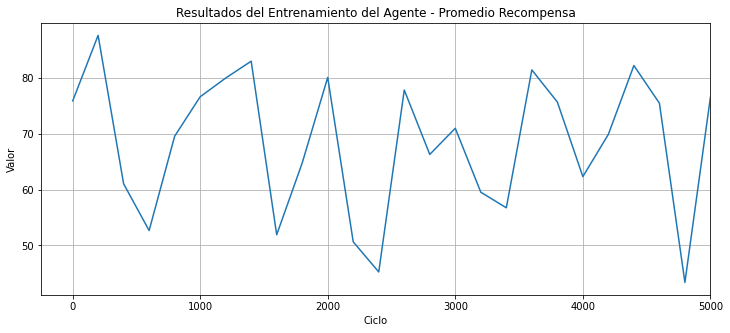

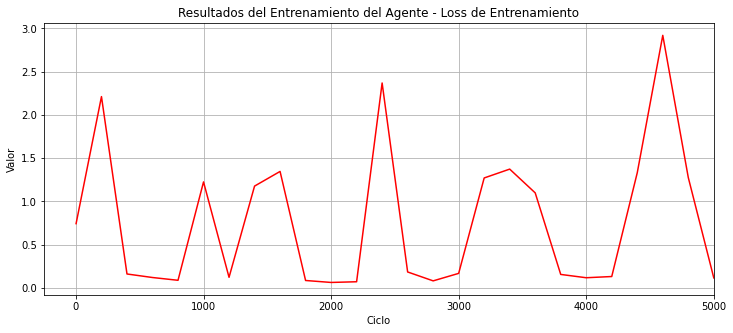

In [14]:
#@title Mostrar Gráficos del Entrenamiento


plt.figure(figsize=(12,5)) 
plt.plot( ar_ciclo, ar_returns)
plt.title("Resultados del Entrenamiento del Agente - Promedio Recompensa")
#plt.legend(['Promedio Recompensa', 'Loss de Entrenamiento'], loc='upper right')
plt.ylabel('Valor')
plt.xlabel('Ciclo')
plt.xlim(right=max(ar_ciclo))   
plt.grid(True)
plt.show()

plt.figure(figsize=(12,5)) 
#plt.plot( ar_ciclo, ar_returns)
plt.plot( ar_ciclo, ar_loss, color="red" )
plt.title("Resultados del Entrenamiento del Agente - Loss de Entrenamiento")
#plt.legend(['Promedio Recompensa', 'Loss de Entrenamiento'], loc='upper right')
plt.ylabel('Valor')
plt.xlabel('Ciclo')
plt.xlim(right=max(ar_ciclo))   
plt.grid(True)
plt.show()


4) Cargar / Graba el modelo de las políticas entrenadas:

In [18]:
#@title Cargar o Guardar el Modelo
# parámetros
directorio_modelo = '/content/gdrive/MyDrive/IA/demoAgentes/Modelos' #@param {type:"string"}
nombre_modelo_grabar = "policy-RandomPosProblem-DQNc-mapa" #@param {type:"string"}
accion_realizar = "-" #@param ["-", "Cargar Modelo", "Grabar Modelo"]

# determina lugar donde se guarda el modelo
policy_dir = os.path.join(directorio_modelo, nombre_modelo_grabar)

if accion_realizar != "-":
  # Montar Drive
  from google.colab import drive
  drive.mount('/content/gdrive')
if accion_realizar == "Grabar Modelo":
  # guarda la politica del agente entrenado
  tf_policy_saver = policy_saver.PolicySaver(ag.policy)
  tf_policy_saver.save(policy_dir)
  print("\nPolítica del modelo guardada en ", policy_dir)
elif accion_realizar == "Cargar Modelo":
  # carga la política del modelo
  saved_policy = tf.compat.v2.saved_model.load(policy_dir)
  print("\nPolítica del modelo recuperada de ", policy_dir)

5) Probar entrenamiento comparando resultados:

In [16]:
#@title Realizar una prueba del Agente Entrenado contra el Azar
Max_Iteraciones_Entorno_para_probar =  100#@param {type:"integer"}
if Max_Iteraciones_Entorno_para_probar < 1:
  Max_Iteraciones_Entorno_para_probar = 1
Usar_hash_para_probar = False #@param {type:"boolean"}
Hash_configuracion_Mapa_Busqueda_probar = "gANjX19tYWluX18KTWFwYUJ1c3F1ZWRhCnEAKYFxAX1xAihYBgAAAGxpbU1pbnEDShj8//9YBgAA AGxpbU1heHEETegDWAcAAABjYW50TWF4cQVLA1gKAAAATWF4aW1vc1Bvc3EGXXEHKF1xCChN3gFK kP///2VdcQkoTRkDSoH///9lXXEKKE0gA0oW/f//ZV1xCyhLhk0KAmVlWAoAAABNYXhpbW9zVmFs cQxdcQ0oS2BLYkshSx1lWAsAAABNYXhPcHRpbW9JRHEOSwF1Yi4=" #@param {type:"string"}
if Usar_hash_para_probar:
  hash = Hash_configuracion_Mapa_Busqueda_probar
else:
  hash = None

# variable auxiliares
cantidad_probar =  1
promAzar = 0
promAgente = 0

# determina política a usar
policy_agente_entrenado = None
if not('ag' in vars() or 'ag' in globals()) or ag is None:
  if not('saved_policy' in vars() or 'saved_policy' in globals()) or saved_policy is None:
    ValueError("No hay política entrenada definida.")
  else:
    policy_agente_entrenado = saved_policy
    print("- Se usa la política recuperada del drive.")
else:
  policy_agente_entrenado = ag.policy
  print("- Se usa la política del modelo entrenado.")

for i in range(cantidad_probar):

  if cantidad_probar > 1:
    print("\n> Prueba ", i+1, ":")

  # crea nuevo entorno que mantiene el espacio de búsqueda
  prueba_env =  tf_py_environment.TFPyEnvironment( BuscarMaxMapaEntorno(Max_Iteraciones_Entorno_para_probar, False, hash) )

  # Probar Aleatorio
  valorAzar = SimularEntorno(prueba_env, random_policy, "Resultados Aleatorio", False) 
  promAzar = promAzar + valorAzar
  
  print("\n ************************************************************************************************************")
  
  # Probar Agente Entrenado
  valorAgente = SimularEntorno(prueba_env, policy_agente_entrenado, "Resultados de Agente Entrenado", False) 
  promAgente = promAgente + valorAgente

  # Decide Ganador
  if valorAzar < valorAgente:
    print("\n--> El Agente Entrenado (", valorAgente,") genera MEJOR resultado que el azar (", valorAzar,")")
  else:
    print("\n--> El Agente Entrenado (", valorAgente,") genera PEOR resultado que el azar (", valorAzar,")")

# Decide Ganador General
if cantidad_probar > 1:
  promAgente = promAgente / cantidad_probar
  promAzar = promAzar / cantidad_probar
  print("\n================================================================================================\n")
  if promAzar < promAgente:
    print("= En promedio, el Agente Entrenado (", promAgente,") tiene MEJORES resultado que  el azar (", promAzar,")")
  else:
    print("= En promedio, el Agente Entrenado (", promAgente,") tiene PEORES resultados que el azar (", promAzar,")")
  print("\n================================================================================================\n")

Output hidden; open in https://colab.research.google.com to view.

In [17]:
#@title Realizar varias pruebas del Agente Entrenado contra el Azar 
Max_Iteraciones_Entorno_para_probar = 100 #@param {type:"integer"}
if Max_Iteraciones_Entorno_para_probar < 1:
  Max_Iteraciones_Entorno_para_probar = 1
Usar_hash_para_probar = False #@param {type:"boolean"}
Hash_configuracion_Mapa_Busqueda_probar = "gANjX19tYWluX18KTWFwYUJ1c3F1ZWRhCnEAKYFxAX1xAihYBgAAAGxpbU1pbnEDShj8//9YBgAA AGxpbU1heHEETegDWAcAAABjYW50TWF4cQVLA1gKAAAATWF4aW1vc1Bvc3EGXXEHKF1xCChN3gFK kP///2VdcQkoTRkDSoH///9lXXEKKE0gA0oW/f//ZV1xCyhLhk0KAmVlWAoAAABNYXhpbW9zVmFs cQxdcQ0oS2BLYkshSx1lWAsAAABNYXhPcHRpbW9JRHEOSwF1Yi4=" #@param {type:"string"}
if Usar_hash_para_probar:
  hash = Hash_configuracion_Mapa_Busqueda_probar
else:
  hash = None

# variable auxiliares
cantidad_probar =  100 #@param {type:"integer"}

# determina política a usar
policy_agente_entrenado = None
if not('ag' in vars() or 'ag' in globals()) or ag is None:
  if not('saved_policy' in vars() or 'saved_policy' in globals()) or saved_policy is None:
    ValueError("No hay política entrenada definida.")
  else:
    policy_agente_entrenado = saved_policy
    print("- Se usa la política recuperada del drive.")
else:
  policy_agente_entrenado = ag.policy
  print("- Se usa la política del modelo entrenado.")


# crea nuevo entorno que mantiene el espacio de búsqueda
prueba_env =  tf_py_environment.TFPyEnvironment( BuscarMaxMapaEntorno(Max_Iteraciones_Entorno_para_probar, False, hash) )

# calcula promedio de política al azar
promAzar = compute_avg_return(prueba_env, random_policy, num_episodes=cantidad_probar)

# calcula promedio de política del agente entrenado
promAgente = compute_avg_return(prueba_env, policy_agente_entrenado, num_episodes=cantidad_probar)

# Decide Ganador General
print("\n================================================================================================\n")
if promAzar < promAgente:
  print("= En promedio, el Agente Entrenado (", promAgente,") tiene MEJORES resultado que  el azar (", round(promAzar, 3),")")
else:
  print("= En promedio, el Agente Entrenado (", promAgente,") tiene PEORES resultados que el azar (", round(promAzar, 3),")")
print("\n================================================================================================\n")

- Se usa la política del modelo entrenado.


= En promedio, el Agente Entrenado ( 53.335114 ) tiene MEJORES resultado que  el azar ( 45.655 )


